In [121]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sentiment Analysis imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import nltk
from nltk.corpus import stopwords
import validators # check if str is url
import re

In [122]:
nltk.download('punkt') # need to download punkt package from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [123]:
def fixed_df(df):
    """
    This function manipulates a DataFrame by handling specific columns and reassembling the DataFrame 
    based on the location of NaN values in the 'user_id' and 'tweet_id' columns.

    Parameters:
    df (pandas.DataFrame): A DataFrame that should contain at least the following columns: 'Unnamed: 0', 
                           'Unnamed: 0.1' (optional), 'user_id', and 'tweet_id'. 

    Returns:
    pandas.DataFrame: The manipulated DataFrame after handling the specific columns and removing NaN values.

    Note:
    1. If 'Unnamed: 0.1' column is present in the DataFrame, it handles both 'Unnamed: 0' and 'Unnamed: 0.1' 
       columns. The DataFrame is then split based on the location of the first NaN in the 'user_id' 
       and 'tweet_id' columns. The DataFrame is reassembled after dropping these columns and re-aligning the column names.
    2. If a NaN is found in 'user_id' column before 'tweet_id' column, it prints 'change the function!'.
    3. If 'Unnamed: 0.1' column is not present in the DataFrame, it only handles the 'Unnamed: 0' column. The DataFrame 
       is split based on the location of the first NaN in 'user_id' column and reassembled after dropping this column.
    """
    if 'Unnamed: 0.1' in df.columns:
        df['Unnamed: 0'] = df['Unnamed: 0'].astype(str)
        df['Unnamed: 0.1'] = df['Unnamed: 0.1'].astype(str)
        numpy_arr = df.to_numpy()
        data = []
        for i, x in enumerate(df['user_id']):
            if np.isnan(x):
                user_id_nan_index = i 
                break
        for i, x in enumerate(df['tweet_id']):
            if np.isnan(x):
                tweet_id_nan_index = i 
                break
        if user_id_nan_index <= tweet_id_nan_index:
            a1 = df[:user_id_nan_index].drop(['Unnamed: 0', 'Unnamed: 0.1'], axis='columns')
            a2 = df[user_id_nan_index:tweet_id_nan_index].drop(['Unnamed: 0.1', 'user_id'], axis='columns')
            a2.columns = a1.columns
            a3 = df[tweet_id_nan_index:].drop(['tweet_id', 'user_id'], axis='columns')
            a3.columns = a1.columns
            return pd.concat([a1, a2, a3])
        else:
            print('change the function!')
    else: # Unnamed: 0.1 col is not exist!
        df['Unnamed: 0'] = df['Unnamed: 0'].astype(str)
        numpy_arr = df.to_numpy()
        data = []
        for i, x in enumerate(df['user_id']):
            if np.isnan(x):
                user_id_nan_index = i 
                break
            else:
                return df.drop(['Unnamed: 0'], axis='columns')
        a1 = df[:user_id_nan_index].drop(['Unnamed: 0'], axis='columns')
        a2 = df[user_id_nan_index:].drop(['user_id'], axis='columns')
        a2.columns = a1.columns
        return pd.concat([a1, a2])
    
    
def merge_topic_data(path_folder):
    """
    This function merges individual CSV files that contain Twitter topic data into a single pandas DataFrame. 
    Each CSV file is assumed to correspond to a particular year (from 2015 to 2022, inclusive) and a specific topic, 
    located within a topic-specific subfolder under the provided directory path.

    Parameters:
    path_folder (str): The path to the folder containing topic subfolders. 
                       Each subfolder should contain CSV files named by year, e.g. '2015.csv'.
                       
    Returns:
    main_df (pandas.DataFrame): The resultant DataFrame after merging all the relevant CSV files.
                                 Columns include 'date', 'user', 'tweet', 'likes', 'replies', 'retweets', 
                                 'hashtags', 'tweet_id', 'user_id', 'topic', and 'year'.

    Note:
    1. If a CSV file contains a column named 'Unnamed: 0', the function will print the topic and year, 
       then call the 'fixed_df' function (not defined in this scope).
    2. The function will add a 'topic' column to the DataFrame, where each entry corresponds to the topic 
       of the source CSV file.
    3. The function will also add a 'year' column to the DataFrame, where each entry corresponds to the year 
       of the source CSV file.
    """
    topics = os.listdir(path_folder)
    columns = [
        'date', 'user', 'tweet', 'likes', 'replies', 'retweets', 'hashtags', 'tweet_id', 'user_id'
    ]   
    main_df = pd.DataFrame(columns=columns + ['topic', 'year'])
    data_frames = []
    
    for topic in topics:
        topic_folder = path_folder + topic
        
        for year in range(2015, 2023):
            csv_file = os.path.join(topic_folder, f'{year}.csv')
       
            if os.path.exists(csv_file):
                df = pd.read_csv(csv_file)
                if 'Unnamed: 0' in df.columns:
#                     print(f'Topic: {topic}, Year: {year}')
                    fixed_df(df)
                df['topic'] = topic
                df['year'] = year
                data_frames.append(df)
                
    main_df = pd.concat(data_frames, ignore_index=True)
    return main_df


def create_smaller_df(df, num_tweets_per_topic=10000):
    """
    Create a smaller dataframe from a larger dataframe of tweets, ensuring a balanced distribution of tweets across topics and years.

    Parameters:
    df (pandas.DataFrame): The original dataframe, which contains columns for 'topic', 'year', and 'value'.
    num_tweets_per_topic (int, optional): The target number of tweets per topic in the smaller dataframe. Defaults to 10000.

    Returns:
    pandas.DataFrame: The smaller dataframe, which contains approximately num_tweets_per_topic tweets for each topic, distributed as evenly as possible across years.

    The function works as follows:
    - For each unique topic in the original dataframe, it creates a subset of the dataframe for that topic.
    - If the topic has fewer than num_tweets_per_topic tweets, it includes all of them in the smaller dataframe.
    - Otherwise, it calculates the proportion of tweets for each year and uses this to determine the number of tweets to take from each year.
    - It then sorts the tweets for each year by 'value' and takes the top tweets up to the calculated number.
    - It continues this process until it has added approximately num_tweets_per_topic tweets for the topic to the smaller dataframe, or until it has added all available tweets for the topic.
    - Finally, it concatenates all the smaller dataframes into one and returns the result.
    """
    topics = df['topic'].unique()
    smaller_dfs = []

    for topic in topics:
        topic_df = df[df['topic'] == topic]

        if len(topic_df) <= num_tweets_per_topic:
            smaller_dfs.append(topic_df)
        else:
            years = topic_df['year'].unique()
            num_tweets_added = 0

            for year in years:
                year_df = topic_df[topic_df['year'] == year]
                year_proportion = len(year_df) / len(topic_df)
                num_tweets_to_add = int(num_tweets_per_topic * year_proportion)

                if num_tweets_added + num_tweets_to_add > num_tweets_per_topic:
                    num_tweets_to_add = num_tweets_per_topic - num_tweets_added

                top_tweets = year_df.sort_values('value', ascending=False).head(num_tweets_to_add)
                smaller_dfs.append(top_tweets)
                num_tweets_added += num_tweets_to_add

                if num_tweets_added >= num_tweets_per_topic:
                    break

    smaller_df = pd.concat(smaller_dfs)

    return smaller_df.reset_index(drop=True)

In [124]:
# path to the folder that contains all the topics
topics_folder = '../../Legalization topics/'

### Merge all the csv files to one data frame

In [125]:
%%time
main_df = merge_topic_data(topics_folder)
main_df

C:\Users\admin\AppData\Local\Temp\ipykernel_3688\1357292731.py:96: DtypeWarning: Columns (0,1,3,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


CPU times: total: 4min 17s
Wall time: 4min 25s


,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year,Unnamed: 0,Unnamed: 0.1
0,2015-04-06 23:59:41+00:00,NandoLago,@FlouridaKylos cannabis,0,0,0,NaN,5.852304e+17,8.327668e+07,cannabis,2015,NaN,NaN
1,2015-04-06 23:59:21+00:00,_MarihuanaLegal,blazedbrohammad:hey my stoners http://t.co/blu...,0,0,0,"['weed', 'marihuana', 'legal', 'cannabis']",5.852303e+17,2.164108e+09,cannabis,2015,NaN,NaN
2,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,NaN,5.852302e+17,1.439516e+09,cannabis,2015,NaN,NaN
3,2015-04-06 23:57:32+00:00,weedpraylove,"This LED lamp charges an iPhone, an Apple Watc...",0,0,0,"['marijuana', 'cannabis']",5.852299e+17,2.864267e+09,cannabis,2015,NaN,NaN
4,2015-04-06 23:57:31+00:00,weedpraylove,10 deep 'Fast and Furious' quotes to get you p...,0,0,0,"['marijuana', 'cannabis']",5.852299e+17,2.864267e+09,cannabis,2015,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30500704,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,NaN,1.609045e+18,2.284169e+09,weed,2022,NaN,NaN
30500705,2022-12-31 04:34:08+00:00,onsaledrones,"Drone drops weed, rolling papers at Kingston c...",0,0,0,NaN,1.609045e+18,1.258472e+18,weed,2022,NaN,NaN
30500706,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,NaN,1.609045e+18,1.897680e+08,weed,2022,NaN,NaN
30500707,2022-12-31 04:34:05+00:00,Biglad832,"Pronouns: he/him\r\nHeight: 6'3""\r\nShoe Size:...",0,0,0,NaN,1.609045e+18,1.509786e+18,weed,2022,NaN,NaN


### Drop non-relevant columns

In [126]:
main_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis='columns')
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:59:41+00:00,NandoLago,@FlouridaKylos cannabis,0,0,0,NaN,5.852304e+17,8.327668e+07,cannabis,2015
1,2015-04-06 23:59:21+00:00,_MarihuanaLegal,blazedbrohammad:hey my stoners http://t.co/blu...,0,0,0,"['weed', 'marihuana', 'legal', 'cannabis']",5.852303e+17,2.164108e+09,cannabis,2015
2,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,NaN,5.852302e+17,1.439516e+09,cannabis,2015
3,2015-04-06 23:57:32+00:00,weedpraylove,"This LED lamp charges an iPhone, an Apple Watc...",0,0,0,"['marijuana', 'cannabis']",5.852299e+17,2.864267e+09,cannabis,2015
4,2015-04-06 23:57:31+00:00,weedpraylove,10 deep 'Fast and Furious' quotes to get you p...,0,0,0,"['marijuana', 'cannabis']",5.852299e+17,2.864267e+09,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
30500704,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,NaN,1.609045e+18,2.284169e+09,weed,2022
30500705,2022-12-31 04:34:08+00:00,onsaledrones,"Drone drops weed, rolling papers at Kingston c...",0,0,0,NaN,1.609045e+18,1.258472e+18,weed,2022
30500706,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,NaN,1.609045e+18,1.897680e+08,weed,2022
30500707,2022-12-31 04:34:05+00:00,Biglad832,"Pronouns: he/him\r\nHeight: 6'3""\r\nShoe Size:...",0,0,0,NaN,1.609045e+18,1.509786e+18,weed,2022


### Remove duplicates rows

In [127]:
main_df.drop_duplicates(inplace=True)
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:59:41+00:00,NandoLago,@FlouridaKylos cannabis,0,0,0,NaN,5.852304e+17,8.327668e+07,cannabis,2015
1,2015-04-06 23:59:21+00:00,_MarihuanaLegal,blazedbrohammad:hey my stoners http://t.co/blu...,0,0,0,"['weed', 'marihuana', 'legal', 'cannabis']",5.852303e+17,2.164108e+09,cannabis,2015
2,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,NaN,5.852302e+17,1.439516e+09,cannabis,2015
3,2015-04-06 23:57:32+00:00,weedpraylove,"This LED lamp charges an iPhone, an Apple Watc...",0,0,0,"['marijuana', 'cannabis']",5.852299e+17,2.864267e+09,cannabis,2015
4,2015-04-06 23:57:31+00:00,weedpraylove,10 deep 'Fast and Furious' quotes to get you p...,0,0,0,"['marijuana', 'cannabis']",5.852299e+17,2.864267e+09,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
30500704,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,NaN,1.609045e+18,2.284169e+09,weed,2022
30500705,2022-12-31 04:34:08+00:00,onsaledrones,"Drone drops weed, rolling papers at Kingston c...",0,0,0,NaN,1.609045e+18,1.258472e+18,weed,2022
30500706,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,NaN,1.609045e+18,1.897680e+08,weed,2022
30500707,2022-12-31 04:34:05+00:00,Biglad832,"Pronouns: he/him\r\nHeight: 6'3""\r\nShoe Size:...",0,0,0,NaN,1.609045e+18,1.509786e+18,weed,2022


### Drop non-relevant tweets
#### Remove all the tweets that have no likes/replies/retweets 

In [128]:
main_df = main_df[(main_df.likes!=0) | (main_df.replies!=0) | (main_df.retweets!=0)]
main_df.reset_index(inplace=True, drop=True)
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,NaN,5.852302e+17,1.439516e+09,cannabis,2015
1,2015-04-06 23:57:27+00:00,weedpraylove,RT QuartzEnail: Will Aaron Hernandez Get Away ...,1,0,0,"['Marijuana', 'Cannabis', 'MMOT', 'MMJ']",5.852299e+17,2.864267e+09,cannabis,2015
2,2015-04-06 23:56:43+00:00,KurtschusterP,#LeyAutocultivo que bueno q esos ancianos van ...,1,0,0,['LeyAutocultivo'],5.852297e+17,6.092715e+08,cannabis,2015
3,2015-04-06 23:55:24+00:00,weedpraylove,A D.C. doctor makes medical marijuana a specia...,1,0,0,"['media', 'p2', 'mmot', 'mmj', 'news', 'cannab...",5.852293e+17,2.864267e+09,cannabis,2015
4,2015-04-06 23:55:22+00:00,weedpraylove,| MEDICATING UNDER THIS NICE TREE |\r#MONDAZE ...,1,0,0,"['MONDAZE', 'JOINT', 'RAWLIFE247', 'CANNABIS',...",5.852293e+17,2.864267e+09,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
14904303,2022-12-31 04:34:46+00:00,nickhexum311,smoking this weed called Frasier Strain,18,1,0,NaN,1.609045e+18,1.397810e+08,weed,2022
14904304,2022-12-31 04:34:40+00:00,Weed_Genics,A really good indica strain may help! #mmj\r\n...,27,0,13,"['mmj', 'Mmemberville', '420life', 'IAmCannabis']",1.609045e+18,1.151265e+18,weed,2022
14904305,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,NaN,1.609045e+18,2.284169e+09,weed,2022
14904306,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,NaN,1.609045e+18,1.897680e+08,weed,2022


## Dealing with missing data

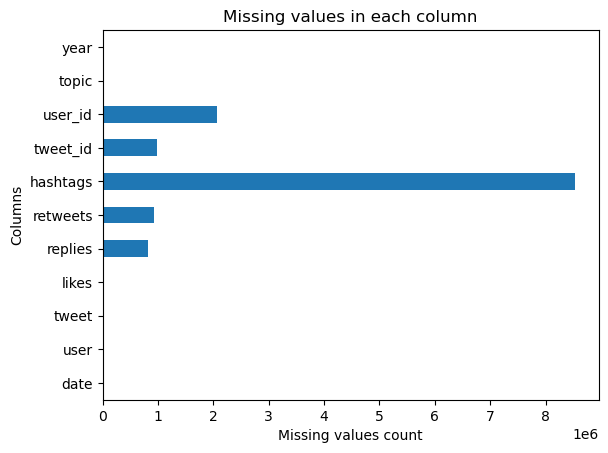

In [129]:
main_df.isnull().sum().plot(kind='barh')
plt.title('Missing values in each column')
plt.ylabel('Columns')
plt.xlabel('Missing values count')
plt.show()

### Remove NA values (without hashtags column)

In [130]:
columns_except_hashtags = main_df.columns.difference(['hashtags'])
main_df.dropna(subset=columns_except_hashtags, inplace=True)
main_df.reset_index(inplace=True, drop=True)
main_df

C:\Users\admin\AppData\Local\Temp\ipykernel_3688\2472735324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df.dropna(subset=columns_except_hashtags, inplace=True)


,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,NaN,5.852302e+17,1.439516e+09,cannabis,2015
1,2015-04-06 23:57:27+00:00,weedpraylove,RT QuartzEnail: Will Aaron Hernandez Get Away ...,1,0,0,"['Marijuana', 'Cannabis', 'MMOT', 'MMJ']",5.852299e+17,2.864267e+09,cannabis,2015
2,2015-04-06 23:56:43+00:00,KurtschusterP,#LeyAutocultivo que bueno q esos ancianos van ...,1,0,0,['LeyAutocultivo'],5.852297e+17,6.092715e+08,cannabis,2015
3,2015-04-06 23:55:24+00:00,weedpraylove,A D.C. doctor makes medical marijuana a specia...,1,0,0,"['media', 'p2', 'mmot', 'mmj', 'news', 'cannab...",5.852293e+17,2.864267e+09,cannabis,2015
4,2015-04-06 23:55:22+00:00,weedpraylove,| MEDICATING UNDER THIS NICE TREE |\r#MONDAZE ...,1,0,0,"['MONDAZE', 'JOINT', 'RAWLIFE247', 'CANNABIS',...",5.852293e+17,2.864267e+09,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
12835859,2022-12-31 04:34:46+00:00,nickhexum311,smoking this weed called Frasier Strain,18,1,0,NaN,1.609045e+18,1.397810e+08,weed,2022
12835860,2022-12-31 04:34:40+00:00,Weed_Genics,A really good indica strain may help! #mmj\r\n...,27,0,13,"['mmj', 'Mmemberville', '420life', 'IAmCannabis']",1.609045e+18,1.151265e+18,weed,2022
12835861,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,NaN,1.609045e+18,2.284169e+09,weed,2022
12835862,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,NaN,1.609045e+18,1.897680e+08,weed,2022


### Fill empty list for NaN values in hashtags column

In [131]:
main_df.hashtags = main_df.hashtags.apply(lambda x: x if pd.notnull(x) else [])

C:\Users\admin\AppData\Local\Temp\ipykernel_3688\2761329583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df.hashtags = main_df.hashtags.apply(lambda x: x if pd.notnull(x) else [])


In [132]:
main_df.isnull().sum()

date        0
user        0
tweet       0
likes       0
replies     0
retweets    0
hashtags    0
tweet_id    0
user_id     0
topic       0
year        0
dtype: int64

In [133]:
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,[],5.852302e+17,1.439516e+09,cannabis,2015
1,2015-04-06 23:57:27+00:00,weedpraylove,RT QuartzEnail: Will Aaron Hernandez Get Away ...,1,0,0,"['Marijuana', 'Cannabis', 'MMOT', 'MMJ']",5.852299e+17,2.864267e+09,cannabis,2015
2,2015-04-06 23:56:43+00:00,KurtschusterP,#LeyAutocultivo que bueno q esos ancianos van ...,1,0,0,['LeyAutocultivo'],5.852297e+17,6.092715e+08,cannabis,2015
3,2015-04-06 23:55:24+00:00,weedpraylove,A D.C. doctor makes medical marijuana a specia...,1,0,0,"['media', 'p2', 'mmot', 'mmj', 'news', 'cannab...",5.852293e+17,2.864267e+09,cannabis,2015
4,2015-04-06 23:55:22+00:00,weedpraylove,| MEDICATING UNDER THIS NICE TREE |\r#MONDAZE ...,1,0,0,"['MONDAZE', 'JOINT', 'RAWLIFE247', 'CANNABIS',...",5.852293e+17,2.864267e+09,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
12835859,2022-12-31 04:34:46+00:00,nickhexum311,smoking this weed called Frasier Strain,18,1,0,[],1.609045e+18,1.397810e+08,weed,2022
12835860,2022-12-31 04:34:40+00:00,Weed_Genics,A really good indica strain may help! #mmj\r\n...,27,0,13,"['mmj', 'Mmemberville', '420life', 'IAmCannabis']",1.609045e+18,1.151265e+18,weed,2022
12835861,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,[],1.609045e+18,2.284169e+09,weed,2022
12835862,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,[],1.609045e+18,1.897680e+08,weed,2022


## Organize data frame columns

In [134]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12835864 entries, 0 to 12835863
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   user      object 
 2   tweet     object 
 3   likes     int64  
 4   replies   object 
 5   retweets  object 
 6   hashtags  object 
 7   tweet_id  float64
 8   user_id   float64
 9   topic     object 
 10  year      int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 1.1+ GB


### Remove all the instances that's different from int

In [135]:
main_df = main_df[main_df.likes.apply(lambda x: isinstance(x, int))]
main_df = main_df[main_df.replies.apply(lambda x: isinstance(x, int))]
main_df = main_df[main_df.retweets.apply(lambda x: isinstance(x, int))]
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,[],5.852302e+17,1.439516e+09,cannabis,2015
1,2015-04-06 23:57:27+00:00,weedpraylove,RT QuartzEnail: Will Aaron Hernandez Get Away ...,1,0,0,"['Marijuana', 'Cannabis', 'MMOT', 'MMJ']",5.852299e+17,2.864267e+09,cannabis,2015
2,2015-04-06 23:56:43+00:00,KurtschusterP,#LeyAutocultivo que bueno q esos ancianos van ...,1,0,0,['LeyAutocultivo'],5.852297e+17,6.092715e+08,cannabis,2015
3,2015-04-06 23:55:24+00:00,weedpraylove,A D.C. doctor makes medical marijuana a specia...,1,0,0,"['media', 'p2', 'mmot', 'mmj', 'news', 'cannab...",5.852293e+17,2.864267e+09,cannabis,2015
4,2015-04-06 23:55:22+00:00,weedpraylove,| MEDICATING UNDER THIS NICE TREE |\r#MONDAZE ...,1,0,0,"['MONDAZE', 'JOINT', 'RAWLIFE247', 'CANNABIS',...",5.852293e+17,2.864267e+09,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
12835859,2022-12-31 04:34:46+00:00,nickhexum311,smoking this weed called Frasier Strain,18,1,0,[],1.609045e+18,1.397810e+08,weed,2022
12835860,2022-12-31 04:34:40+00:00,Weed_Genics,A really good indica strain may help! #mmj\r\n...,27,0,13,"['mmj', 'Mmemberville', '420life', 'IAmCannabis']",1.609045e+18,1.151265e+18,weed,2022
12835861,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,[],1.609045e+18,2.284169e+09,weed,2022
12835862,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,[],1.609045e+18,1.897680e+08,weed,2022


### Reduce memory usage

In [136]:
print('Maximum int value for np.int16:', int(pow(2,16) / 2))
print('Maximum int value for np.int32:', int(pow(2,32) / 2))
print('Maximum int value for np.int64:', int(pow(2,64) / 2))

Maximum int value for np.int16: 32768
Maximum int value for np.int32: 2147483648
Maximum int value for np.int64: 9223372036854775808


In [137]:
max(main_df.likes) < int(pow(2,32) / 2)

True

In [138]:
max(main_df.replies) < int(pow(2,16) / 2)

True

In [139]:
max(main_df.retweets) < int(pow(2,32) / 2)

True

In [140]:
max(main_df.tweet_id) < int(pow(2,64) / 2)

True

In [141]:
max(main_df.user_id) < int(pow(2,64) / 2)

True

In [142]:
main_df.date = pd.to_datetime(main_df.date)
main_df.likes = main_df.likes.astype(np.int32)
main_df.replies = main_df.replies.astype(np.int16)
main_df.retweets = main_df.retweets.astype(np.int32)
main_df.tweet_id = main_df.tweet_id.astype(np.int64)
main_df.user_id = main_df.user_id.astype(np.int64)
main_df.year = main_df.year.astype(np.int16)
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,[],585230174129618944,1439515524,cannabis,2015
1,2015-04-06 23:57:27+00:00,weedpraylove,RT QuartzEnail: Will Aaron Hernandez Get Away ...,1,0,0,"['Marijuana', 'Cannabis', 'MMOT', 'MMJ']",585229865026224128,2864267228,cannabis,2015
2,2015-04-06 23:56:43+00:00,KurtschusterP,#LeyAutocultivo que bueno q esos ancianos van ...,1,0,0,['LeyAutocultivo'],585229678308417536,609271461,cannabis,2015
3,2015-04-06 23:55:24+00:00,weedpraylove,A D.C. doctor makes medical marijuana a specia...,1,0,0,"['media', 'p2', 'mmot', 'mmj', 'news', 'cannab...",585229349638516736,2864267228,cannabis,2015
4,2015-04-06 23:55:22+00:00,weedpraylove,| MEDICATING UNDER THIS NICE TREE |\r#MONDAZE ...,1,0,0,"['MONDAZE', 'JOINT', 'RAWLIFE247', 'CANNABIS',...",585229342529183744,2864267228,cannabis,2015
...,...,...,...,...,...,...,...,...,...,...,...
12835859,2022-12-31 04:34:46+00:00,nickhexum311,smoking this weed called Frasier Strain,18,1,0,[],1609045374529945600,139781011,weed,2022
12835860,2022-12-31 04:34:40+00:00,Weed_Genics,A really good indica strain may help! #mmj\r\n...,27,0,13,"['mmj', 'Mmemberville', '420life', 'IAmCannabis']",1609045350719029248,1151265095910957056,weed,2022
12835861,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,[],1609045308255731712,2284168930,weed,2022
12835862,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,[],1609045207496142848,189767993,weed,2022


In [143]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12783730 entries, 0 to 12835863
Data columns (total 11 columns):
 #   Column    Dtype              
---  ------    -----              
 0   date      datetime64[ns, UTC]
 1   user      object             
 2   tweet     object             
 3   likes     int32              
 4   replies   int16              
 5   retweets  int32              
 6   hashtags  object             
 7   tweet_id  int64              
 8   user_id   int64              
 9   topic     object             
 10  year      int16              
dtypes: datetime64[ns, UTC](1), int16(2), int32(2), int64(2), object(4)
memory usage: 926.6+ MB


## Balance the data frame

### Topic column count

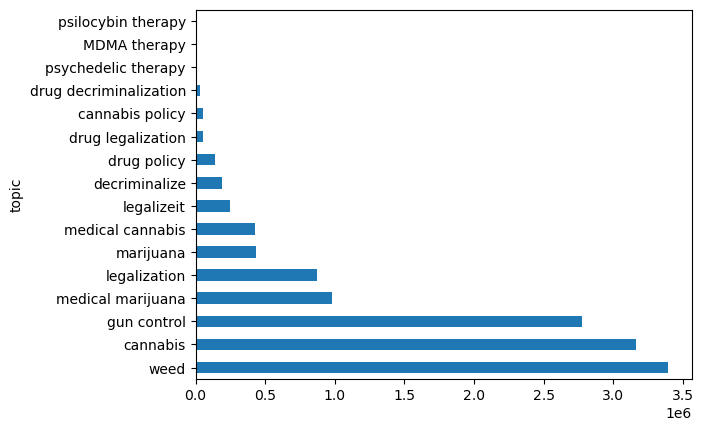

In [144]:
main_df.topic.value_counts().plot(kind='barh')
plt.show()

### Year column count

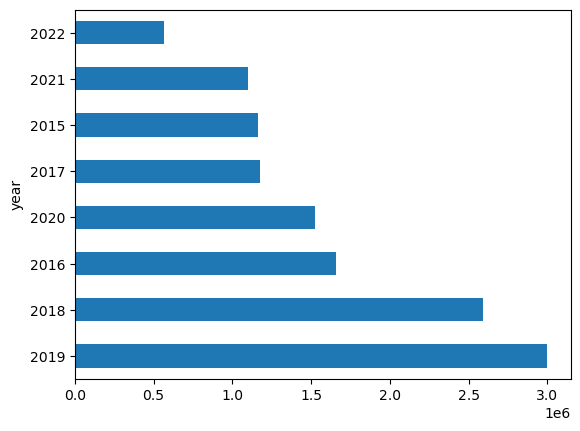

In [145]:
main_df.year.value_counts().plot(kind='barh')
plt.show()

### Create value column
#### value = likes + replies + retweets

In [146]:
main_df['value'] = main_df['likes'] + main_df['replies'] + main_df['retweets']
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year,value
0,2015-04-06 23:58:41+00:00,gusbsants,@Cannabis_fs disq agrediram ele dae ele foi pr...,0,1,0,[],585230174129618944,1439515524,cannabis,2015,1
1,2015-04-06 23:57:27+00:00,weedpraylove,RT QuartzEnail: Will Aaron Hernandez Get Away ...,1,0,0,"['Marijuana', 'Cannabis', 'MMOT', 'MMJ']",585229865026224128,2864267228,cannabis,2015,1
2,2015-04-06 23:56:43+00:00,KurtschusterP,#LeyAutocultivo que bueno q esos ancianos van ...,1,0,0,['LeyAutocultivo'],585229678308417536,609271461,cannabis,2015,1
3,2015-04-06 23:55:24+00:00,weedpraylove,A D.C. doctor makes medical marijuana a specia...,1,0,0,"['media', 'p2', 'mmot', 'mmj', 'news', 'cannab...",585229349638516736,2864267228,cannabis,2015,1
4,2015-04-06 23:55:22+00:00,weedpraylove,| MEDICATING UNDER THIS NICE TREE |\r#MONDAZE ...,1,0,0,"['MONDAZE', 'JOINT', 'RAWLIFE247', 'CANNABIS',...",585229342529183744,2864267228,cannabis,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12835859,2022-12-31 04:34:46+00:00,nickhexum311,smoking this weed called Frasier Strain,18,1,0,[],1609045374529945600,139781011,weed,2022,19
12835860,2022-12-31 04:34:40+00:00,Weed_Genics,A really good indica strain may help! #mmj\r\n...,27,0,13,"['mmj', 'Mmemberville', '420life', 'IAmCannabis']",1609045350719029248,1151265095910957056,weed,2022,40
12835861,2022-12-31 04:34:30+00:00,sanguinesurplus,Me smoking weed is like ok yeah that’s weed,2,0,1,[],1609045308255731712,2284168930,weed,2022,3
12835862,2022-12-31 04:34:06+00:00,coolian2,@Becs Also putting down weed matting and depen...,1,1,0,[],1609045207496142848,189767993,weed,2022,2


### Removing duplicate tweets, saving the tweet with the highest value

In [147]:
main_df = main_df.sort_values('value', ascending=False).drop_duplicates('tweet_id', keep='first')
main_df.reset_index(inplace=True, drop=True)
main_df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year,value
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1269748689184014336,1262905431602589696,legalization,2020,691604
1,2019-03-21 19:30:07+00:00,lem0ngf,“No means no” doesn’t only apply to sex. It al...,459412,821,156671,[],1108813055603941376,508107824,weed,2019,616904
2,2018-02-16 18:50:44+00:00,Sarahchadwickk,"Dear Donald Trump, \r\nI’m the 16 year old gir...",481217,6954,114527,[],964572770930700288,1787201851,gun control,2018,602698
3,2017-10-02 12:58:53+00:00,ClintSmithIII,I want gun control. I want Puerto Rico to have...,426656,3613,166193,[],914837089744801792,472587261,gun control,2017,596462
4,2018-02-22 21:21:40+00:00,bruhthaniel2,the most gun control we’ve had is apple replac...,436796,276,139562,[],966785084828409856,3007497007,gun control,2018,576634
...,...,...,...,...,...,...,...,...,...,...,...,...
11985081,2016-05-26 18:28:02+00:00,dap9573,@Da_Spike So maybe they shouldn't have access ...,0,1,0,[],735900315417878528,2507463707,gun control,2016,1
11985082,2016-02-03 17:27:27+00:00,tomangell,Crowdsource: Do any states currently apply a t...,0,1,0,[],694935242570866688,18013279,medical marijuana,2016,1
11985083,2016-05-26 18:26:00+00:00,TheNewsFlasher,@VulgarMarcus @itsJohn718 Huh? She supported B...,0,1,0,[],735899803691819008,3907341980,gun control,2016,1
11985084,2016-02-03 17:32:18+00:00,MikeLoBurgio,U.S. Veteran's #kids Taken Away Over His Use o...,0,0,1,"['kids', 'MedicalMarijuana', 'ksleg']",694936461062250496,68754498,medical marijuana,2016,1


### Create smaller (balanced) data frame that contains tweets with highest value

In [148]:
df = create_smaller_df(main_df)
df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year,value
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1269748689184014336,1262905431602589696,legalization,2020,691604
1,2020-11-04 23:49:38+00:00,AOC,Shout out to the hard work of grassroots organ...,289942,1573,18519,[],1324136754509713408,138203134,legalization,2020,310034
2,2020-07-28 13:21:06+00:00,MargBarAmerica,i still can't get over the democrats overwhelm...,24154,156,1975,[],1288102179736297472,17109158,legalization,2020,26285
3,2020-12-04 18:27:14+00:00,nytimes,The House has voted to decriminalize marijuana...,18705,715,5606,[],1334927257840873472,807095,legalization,2020,25026
4,2020-07-28 12:57:33+00:00,YesYoureRacist,Good morning! 57% of Americans and 78% of Demo...,15003,117,4613,[],1288096253344186368,858924511,legalization,2020,19733
...,...,...,...,...,...,...,...,...,...,...,...,...
152548,2015-12-29 13:21:28+00:00,lanceb62,Soros Foundation promoted drug legalization wo...,1,0,1,[],681827375206670336,2874372175,drug legalization,2015,2
152549,2015-10-17 15:05:00+00:00,JamieGump,Waiting to hear @TexasGOP say anything about #...,1,0,0,"['DrugLegalization', 'ttf', 'BorderSecurity']",655399116223086592,528261651,drug legalization,2015,1
152550,2015-10-23 12:37:56+00:00,KerryWMartin,"""Police work for #narcos because they pay bett...",0,1,0,"['narcos', 'DrugLegalization']",657536433662636032,2545495004,drug legalization,2015,1
152551,2015-08-01 01:10:26+00:00,PunkRockLiberty,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,0,0,1,[],627285222451589120,1278031291,drug legalization,2015,1


### Drop non-relevant columns

In [149]:
df.drop(['value', 'tweet_id'], inplace=True, axis='columns')
df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1269748689184014336,1262905431602589696,legalization,2020
1,2020-11-04 23:49:38+00:00,AOC,Shout out to the hard work of grassroots organ...,289942,1573,18519,[],1324136754509713408,138203134,legalization,2020
2,2020-07-28 13:21:06+00:00,MargBarAmerica,i still can't get over the democrats overwhelm...,24154,156,1975,[],1288102179736297472,17109158,legalization,2020
3,2020-12-04 18:27:14+00:00,nytimes,The House has voted to decriminalize marijuana...,18705,715,5606,[],1334927257840873472,807095,legalization,2020
4,2020-07-28 12:57:33+00:00,YesYoureRacist,Good morning! 57% of Americans and 78% of Demo...,15003,117,4613,[],1288096253344186368,858924511,legalization,2020
...,...,...,...,...,...,...,...,...,...,...,...
152548,2015-12-29 13:21:28+00:00,lanceb62,Soros Foundation promoted drug legalization wo...,1,0,1,[],681827375206670336,2874372175,drug legalization,2015
152549,2015-10-17 15:05:00+00:00,JamieGump,Waiting to hear @TexasGOP say anything about #...,1,0,0,"['DrugLegalization', 'ttf', 'BorderSecurity']",655399116223086592,528261651,drug legalization,2015
152550,2015-10-23 12:37:56+00:00,KerryWMartin,"""Police work for #narcos because they pay bett...",0,1,0,"['narcos', 'DrugLegalization']",657536433662636032,2545495004,drug legalization,2015
152551,2015-08-01 01:10:26+00:00,PunkRockLiberty,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,0,0,1,[],627285222451589120,1278031291,drug legalization,2015


### Convert all hashtags to lowercase

In [153]:
df['hashtags'] = df['hashtags'].apply(lambda x: str(x).lower())
df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1269748689184014336,1262905431602589696,legalization,2020
1,2020-11-04 23:49:38+00:00,AOC,Shout out to the hard work of grassroots organ...,289942,1573,18519,[],1324136754509713408,138203134,legalization,2020
2,2020-07-28 13:21:06+00:00,MargBarAmerica,i still can't get over the democrats overwhelm...,24154,156,1975,[],1288102179736297472,17109158,legalization,2020
3,2020-12-04 18:27:14+00:00,nytimes,The House has voted to decriminalize marijuana...,18705,715,5606,[],1334927257840873472,807095,legalization,2020
4,2020-07-28 12:57:33+00:00,YesYoureRacist,Good morning! 57% of Americans and 78% of Demo...,15003,117,4613,[],1288096253344186368,858924511,legalization,2020
...,...,...,...,...,...,...,...,...,...,...,...
152548,2015-12-29 13:21:28+00:00,lanceb62,Soros Foundation promoted drug legalization wo...,1,0,1,[],681827375206670336,2874372175,drug legalization,2015
152549,2015-10-17 15:05:00+00:00,JamieGump,Waiting to hear @TexasGOP say anything about #...,1,0,0,"['druglegalization', 'ttf', 'bordersecurity']",655399116223086592,528261651,drug legalization,2015
152550,2015-10-23 12:37:56+00:00,KerryWMartin,"""Police work for #narcos because they pay bett...",0,1,0,"['narcos', 'druglegalization']",657536433662636032,2545495004,drug legalization,2015
152551,2015-08-01 01:10:26+00:00,PunkRockLiberty,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,0,0,1,[],627285222451589120,1278031291,drug legalization,2015


### Import the data frame to csv

In [180]:
df.to_csv('./balanced_df.csv', index=False)

### clean tweets for sentiment analysis

In [155]:
stop_words_set = set(stopwords.words("english"))

In [156]:
df['clean_tweet'] = df['tweet'].str.lower()

In [157]:
for idx, row in df.iterrows():
    text = df.at[idx,'clean_tweet']
    text = ' '.join([s for s in text.split() if (s not in stop_words_set) and (not validators.url(s))])
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    df.at[idx,'clean_tweet'] = " ".join(text.split())

In [158]:
df.isna().sum()

date           0
user           0
tweet          0
likes          0
replies        0
retweets       0
hashtags       0
tweet_id       0
user_id        0
topic          0
year           0
clean_tweet    0
dtype: int64

## Sentiment Analysis

In [160]:
df['sentiment'] = np.nan
df

,date,user,tweet,likes,replies,retweets,hashtags,tweet_id,user_id,topic,year,clean_tweet,sentiment
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1269748689184014336,1262905431602589696,legalization,2020,next docket free every black man unfairly rott...,NaN
1,2020-11-04 23:49:38+00:00,AOC,Shout out to the hard work of grassroots organ...,289942,1573,18519,[],1324136754509713408,138203134,legalization,2020,shout hard work grassroots organizers successf...,NaN
2,2020-07-28 13:21:06+00:00,MargBarAmerica,i still can't get over the democrats overwhelm...,24154,156,1975,[],1288102179736297472,17109158,legalization,2020,still can t get democrats overwhelmingly votin...,NaN
3,2020-12-04 18:27:14+00:00,nytimes,The House has voted to decriminalize marijuana...,18705,715,5606,[],1334927257840873472,807095,legalization,2020,house voted decriminalize marijuana expunge no...,NaN
4,2020-07-28 12:57:33+00:00,YesYoureRacist,Good morning! 57% of Americans and 78% of Demo...,15003,117,4613,[],1288096253344186368,858924511,legalization,2020,good morning 57 americans 78 democrats support...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152548,2015-12-29 13:21:28+00:00,lanceb62,Soros Foundation promoted drug legalization wo...,1,0,1,[],681827375206670336,2874372175,drug legalization,2015,soros foundation promoted drug legalization wo...,NaN
152549,2015-10-17 15:05:00+00:00,JamieGump,Waiting to hear @TexasGOP say anything about #...,1,0,0,"['druglegalization', 'ttf', 'bordersecurity']",655399116223086592,528261651,drug legalization,2015,waiting hear texasgop say anything druglegaliz...,NaN
152550,2015-10-23 12:37:56+00:00,KerryWMartin,"""Police work for #narcos because they pay bett...",0,1,0,"['narcos', 'druglegalization']",657536433662636032,2545495004,drug legalization,2015,police work narcos pay better interview drugle...,NaN
152551,2015-08-01 01:10:26+00:00,PunkRockLiberty,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,0,0,1,[],627285222451589120,1278031291,drug legalization,2015,govt funded anti drug program d a r e called l...,NaN


In [110]:
df.to_csv('sentiment_df.csv', index=False)

In [161]:
roberta = 'cardiffnlp/twitter-roberta-base-sentiment'
model = AutoModelForSequenceClassification.from_pretrained(roberta)
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

In [162]:
def sentiment_analysis(tweet):
    encoded_tweet = roberta_tokenizer(tweet, return_tensors='pt')
    scores = softmax(model(**encoded_tweet)[0][0].detach().numpy())
    return labels[scores.argmax()]

In [166]:
def process_chunk(chunk, sentiment_df):
    chunk['sentiment'] = chunk['clean_tweet'].apply(sentiment_analysis)
    
    # Update the relevant rows of sentiment_df with the processed chunk
    sentiment_df.update(chunk)
    
    return chunk

In [168]:
def process_half(df, half, chunk_size=1000):
    # Determine the start and end indices based on the half parameter
    if half == 'first':
        start_index = 0
        end_index = len(df) // 2
    elif half == 'second':
        start_index = len(df) // 2
        end_index = len(df)
    else:
        raise ValueError("Invalid value for half parameter. Must be 'first' or 'second'.")

    # Get the relevant half of the DataFrame
    df_half = df.iloc[start_index:end_index]

    # If processing the second half, reverse the order of the DataFrame
    if half == 'second':
        df_half = df_half.iloc[::-1]

    # Split the DataFrame into chunks of chunk_size rows
    chunks = np.array_split(df_half, len(df_half) // chunk_size + 1)

    # Check if the sentiment_df.csv file exists
    if os.path.exists('sentiment_df.csv'):
        # If it exists, read it into a DataFrame
        sentiment_df = pd.read_csv('sentiment_df.csv')
    else:
        # If it doesn't exist, create a new DataFrame with the same columns as the input DataFrame
        sentiment_df = pd.DataFrame(columns=df_half.columns)

    # Process each chunk
    for i, chunk in enumerate(chunks):
        start_index_chunk = start_index + i * chunk_size
        end_index_chunk = start_index_chunk + len(chunk) - 1
        processed_chunk = process_chunk(chunk, sentiment_df)
        print(f'Processed chunk {i+1} of {len(chunks)}')

        # Save sentiment_df to a CSV file
        sentiment_df.to_csv('sentiment_df.csv', index=False)

In [171]:
# Process the first half of the DataFrame with a chunk size of 100
process_half(df, 'first', 100)

In [172]:
# Process the first half of the DataFrame with a chunk size of 100
process_half(df, 'second', 100)

In [178]:
df

In [121]:
df.to_csv('sentiment_df.csv', index=False)

In [182]:
fakjsdfh = pd.read_csv('sentiment_df.csv')
fakjsdfh

,date,user,tweet,likes,replies,retweets,hashtags,user_id,topic,year,clean_tweet,sentiment
0,2020-06-07 21:50:52+00:00,brittany_broski,Next up on the docket: free every black man un...,542202,938,148464,[],1262905431602589696,legalization,2020,next docket free every black man unfairly rott...,Positive
1,2020-11-04 23:49:38+00:00,AOC,Shout out to the hard work of grassroots organ...,289942,1573,18519,[],138203134,legalization,2020,shout hard work grassroots organizers successf...,Positive
2,2020-07-28 13:21:06+00:00,MargBarAmerica,i still can't get over the democrats overwhelm...,24154,156,1975,[],17109158,legalization,2020,still can t get democrats overwhelmingly votin...,Negative
3,2020-12-04 18:27:14+00:00,nytimes,The House has voted to decriminalize marijuana...,18705,715,5606,[],807095,legalization,2020,house voted decriminalize marijuana expunge no...,Neutral
4,2020-07-28 12:57:33+00:00,YesYoureRacist,Good morning! 57% of Americans and 78% of Demo...,15003,117,4613,[],858924511,legalization,2020,good morning 57 americans 78 democrats support...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
152451,2015-12-29 13:21:28+00:00,lanceb62,Soros Foundation promoted drug legalization wo...,1,0,1,[],2874372175,drug legalization,2015,soros foundation promoted drug legalization wo...,Neutral
152452,2015-10-17 15:05:00+00:00,JamieGump,Waiting to hear @TexasGOP say anything about #...,1,0,0,"['druglegalization', 'ttf', 'bordersecurity']",528261651,drug legalization,2015,waiting hear texasgop say anything druglegaliz...,Neutral
152453,2015-10-23 12:37:56+00:00,KerryWMartin,"""Police work for #narcos because they pay bett...",0,1,0,"['narcos', 'druglegalization']",2545495004,drug legalization,2015,police work narcos pay better interview drugle...,Neutral
152454,2015-08-01 01:10:26+00:00,PunkRockLiberty,Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...,0,0,1,[],1278031291,drug legalization,2015,govt funded anti drug program d a r e called l...,Neutral
